https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24 참조

In [1]:
import tensorflow as tf

In [2]:
from keras import backend as K
from keras.layers import Input, BatchNormalization, LSTM, Dense, concatenate, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import Adam, SGD
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import random
import matplotlib.pyplot as plt
import os
import cv2
import json

Using TensorFlow backend.


In [3]:
tf.__version__

'2.1.0'

# 1. Define loss & base network
- 두 가지 loss 함수
    - `triplet_loss`
        - 출처: https://thelonenutblog.wordpress.com/2017/12/18/what-siamese-dreams-are-made-of/
    - `lossless_triplet_loss`
        - 출처: https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24

In [4]:
def triplet_loss(y_true, y_pred, N=128, alpha = 0.2):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, not used in this function.
    y_pred -- python list containing three objects:
            anchor:   the encodings for the anchor data
            positive: the encodings for the positive data (similar to anchor)
            negative: the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)))

    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)))

    # compute loss
    basic_loss = pos_dist-neg_dist + alpha

    loss = tf.maximum(basic_loss,0.0)

    return loss

In [5]:
def lossless_triplet_loss(y_true, y_pred, N=128, beta=128, epsilon=1e-8):
    """
    Implementation of the triplet loss function
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    N  --  The number of dimension 
    beta -- The scaling factor, N is recommended
    epsilon -- The Epsilon value to prevent ln(0)
    
    
    Returns:
    loss -- real number, value of the loss
    """
    anchor = tf.convert_to_tensor(y_pred[:,0:N])
    positive = tf.convert_to_tensor(y_pred[:,N:N*2]) 
    negative = tf.convert_to_tensor(y_pred[:,N*2:N*3])
    
    # distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),1)
    # distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),1)
    
    #Non Linear Values  
    
    # -ln(-x/N+1)
    pos_dist = -tf.math.log(-tf.divide((pos_dist),beta)+1+epsilon)
    neg_dist = -tf.math.log(-tf.divide((N-neg_dist),beta)+1+epsilon)
    
    # compute loss
    loss = neg_dist + pos_dist
    
    
    return loss

In [6]:
def cnn_base_network(in_dims, out_dims):
    model = Sequential()

    model.add(Conv2D(input_shape = in_dims,
                     filters = 10, kernel_size = (3,3), strides = (1,1), padding = 'same', activation='relu'))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())    #1차원화

    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(out_dims, activation = 'sigmoid'))

    return model

# 2. Define input generator

In [27]:
data_dir = '../../img/masked_mini_train'   #클래스 5개만 있는 테스트 디렉토리
# data_dir = '../img_moved'      #aws에서 돌릴 때 경로

directory = os.listdir(data_dir)         #이미지 디렉토리들(==클래스들) 리스트
directory.remove( '.DS_Store')     #가끔 포함되어 있는 불순물 제거해주기

CLASS_DICT = {k:v for k, v in enumerate(directory)}     #정수 : 클래스 이름 페어를 원소로 하는 딕셔너리
CLASS_DICT

{0: '(2314)Floral_Print_Maxi_Dress',
 1: '(2020)Eyelet_Fit___Flare_Dress',
 2: '(39)Abstract_Diamond_Print_Dress',
 3: '(199)Abstract_Tile_Print_Dress',
 4: '(20)Abstract_Animal_Print_Dress'}

In [28]:
def input_triplet_gen(gen, data_dir, num_classes, batch_size):
    
    while True:
        anchor_label, neg_label = random.sample(range(0, num_classes), 2)     #라벨 인덱스 2개 뽑기(anchor+pos, neg)

        POS_DIR = os.path.join(data_dir, CLASS_DICT[anchor_label])       #anchor+pos 로 지정할 디렉토리
        NEG_DIR = os.path.join(data_dir, CLASS_DICT[neg_label])           #neg로 지정할 디렉토리
        
        POS_filecount = len(os.listdir(os.path.join(POS_DIR, POS_DIR.split(os.path.sep)[-1])))    #POS_DIR 이미지 개수 (뎁스 2번 들어가야해서 os.path.join~ 해주기)
        NEG_filecount = len(os.listdir(os.path.join(NEG_DIR, NEG_DIR.split(os.path.sep)[-1])))   #NEG_DIR 이미지 개수
        
        if  POS_filecount < batch_size or NEG_filecount < batch_size:    #이미지 개수가 batch_size 미만이면 처음으로 돌아가서 라벨 인덱스 다시 선택
            continue

        anchor_gen = gen.flow_from_directory(POS_DIR, 
                                                      target_size=(150, 150),
                                                     batch_size=batch_size)

        pos_gen = gen.flow_from_directory(POS_DIR, 
                                                      target_size=(150, 150),
                                                     batch_size=batch_size)

        neg_gen = gen.flow_from_directory(NEG_DIR, 
                                                      target_size=(150, 150),
                                                     batch_size=batch_size)
    
#         print("Anchor: {} , Neg: {}".format(anchor_label, neg_label))    #매번 다른 label로 불러오는 것 확인하기 위한 줄
        X1i = anchor_gen.next()
        X2i = pos_gen.next()
        X3i = neg_gen.next()
        
        yield [X1i[0], X2i[0], X3i[0]], X1i[1]

# 3. Create model

In [29]:
in_dims = (150, 150, 3)    # (28, 28, 1)
out_dims = 128

# Create the 3 inputs
anchor_in = Input(shape=in_dims, name='anchor')
pos_in = Input(shape=in_dims, name='positive')
neg_in = Input(shape=in_dims, name='negative')

# with tf.compat.v1.Session(config=config):
    # Share base network with the 3 inputs
base_network = cnn_base_network(in_dims, out_dims)
anchor_out = base_network(anchor_in)
pos_out = base_network(pos_in)
neg_out = base_network(neg_in)
    
merged_vector = concatenate([anchor_out, pos_out, neg_out], axis=-1)

# Define the trainable model
model = Model(inputs=[anchor_in, pos_in, neg_in], outputs=merged_vector)
model.compile(optimizer=Adam(learning_rate=0.0001),
                    loss=lossless_triplet_loss)

In [30]:
base_network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 150, 150, 10)      280       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 148, 148, 64)      5824      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 32)        18464     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 70, 70, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 32)       

In [31]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor (InputLayer)             (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
positive (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
negative (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128)          327928      anchor[0][0]                     
                                                                 positive[0][0]             

# 4. Train

In [32]:
gen = ImageDataGenerator(rescale=1./255)
num_classes = len(CLASS_DICT)
batch_size = 10

`flow_from_directory` 호출 시 출력되는 메세지 주석처리 하기
--> 안 하면 output 엄청 지저분해진다.
- 경로: ~site_packages/keras_preprocessing/image/direcotry_iterator.py
- `belonging`으로 검색해서 `print` 함수 주석처리(line 135-136)

In [33]:
# Training the model
H = model.fit_generator(input_triplet_gen(gen, data_dir, num_classes, batch_size),
                        steps_per_epoch = 10, 
                        epochs=20, 
                        use_multiprocessing=True)

Epoch 1/20
 3/10 [========>.....................] - ETA: 12s - loss: 11.2646

Process ForkPoolWorker-11:
Traceback (most recent call last):
  File "/Users/soothingni/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/soothingni/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/soothingni/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/Users/soothingni/anaconda3/lib/python3.7/site-packages/keras/utils/data_utils.py", line 650, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "<ipython-input-28-05a03219d941>", line 25, in input_triplet_gen
    batch_size=batch_size)
  File "/Users/soothingni/anaconda3/lib/python3.7/site-packages/keras/preprocessing/image.py", line 467, in flow_from_directory
    interpolation=interpolation
  File "/Users/soothingni/anaconda3/lib/python3.7/site-packages/keras/preprocessing/image.py", line 150, in __init__
    d

Epoch 1/20


KeyboardInterrupt: 

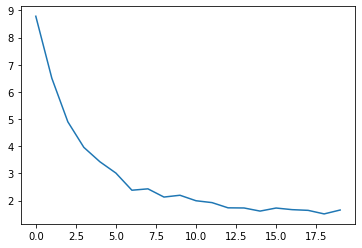

In [20]:
#결과 확인
plt.plot(H.history['loss'])
# plt.savefig('./CNN/loss_graph.png')
# plt.legend(['loss'], loc = 'upper left')
plt.show()

# 5. Save model & weights

In [20]:
model_dir = './trained/lossless_triplet.json'
model_weights_dir = './trained/lossless_triplet.h5'

In [21]:
#Save model
model_json = model.to_json()
with open(model_dir, "w") as json_file : 
    json_file.write(model_json)

#Save weights
model.save_weights(model_weights_dir)
print("Saved model to disk")

Saved model to disk


In [22]:
#Load model & weights
from keras.models import model_from_json
json_file = open(model_dir, "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(model_weights_dir)
print("Loaded model from disk")

Loaded model from disk


# 6. Test

In [22]:
def item_to_encoding(item, model):
    return model.predict(np.array([item]))

## 6.1 Load test data

In [35]:
test_dir = '../img/masked_mini_test'    #클래스 5개만 있는 테스트 디렉토리

In [36]:
test_batch_size = 2000    #이미지 전부 다 불러올 수 있게 충분히 큰 수로 지정한다.

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                        data_dir,  # this is the target directory
                        target_size=(150, 150),  # 모든 이미지의 크기가 150x150로 조정됩니다.
                        batch_size=test_batch_size)

batch = test_generator.next()
images = batch[0]
labels = batch[1]

# images = images.reshape(-1, 150, 150)
labels = np.array([np.argmax(x) for x in labels])

Found 185 images belonging to 5 classes.


In [37]:
def get_triplets(x, y, sample_size):
    a = []
    p = []
    n = []
    
    num_classes = len(set(y))
    for _ in range(sample_size):
        num1, num2 = random.sample(range(num_classes), 2)
        positive_pool = x[np.where(y == num1)[0]]
        negative_pool = x[np.where(y == num2)[0]]
        num3, num4 = random.sample(range(len(positive_pool)), 2)

        anchor = positive_pool[num3]
        positive = positive_pool[num4]
        negative = negative_pool[random.randint(0, len(negative_pool)-1)]
        
        a.append(anchor)
        p.append(positive)
        n.append(negative)
        
    return np.asarray(a), np.asarray(p), np.asarray(n)

In [38]:
sample_size = 200    #250 이상으로 하면 커널이 죽습니다.... 함수가 별로에요
t_a, t_p, t_n = get_triplets(images, labels, sample_size)

## 6.2 triplet test

---------- wrong embedding : index 2 -----------


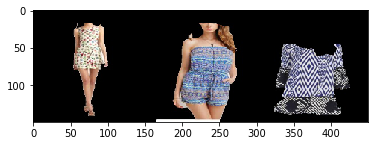

---------- wrong embedding : index 35 -----------


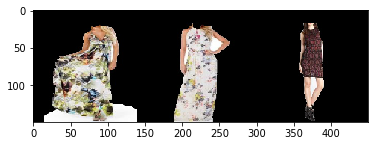

---------- wrong embedding : index 57 -----------


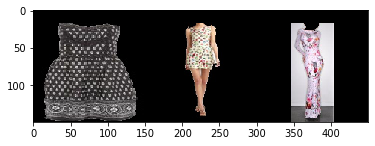

---------- wrong embedding : index 62 -----------


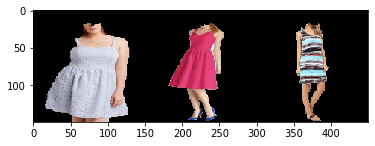

---------- wrong embedding : index 70 -----------


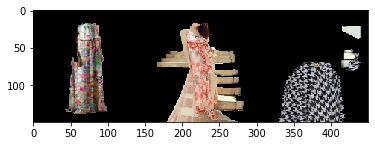

---------- wrong embedding : index 74 -----------


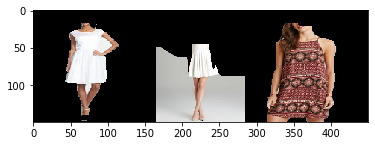

---------- wrong embedding : index 80 -----------


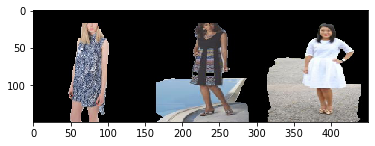

---------- wrong embedding : index 81 -----------


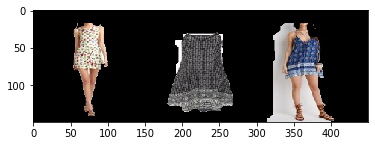

---------- wrong embedding : index 83 -----------


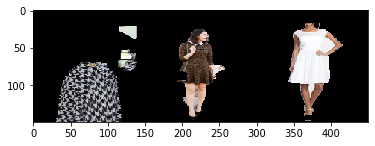

---------- wrong embedding : index 94 -----------


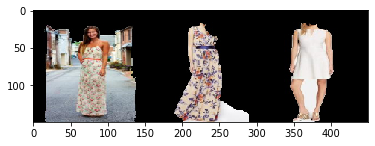

---------- wrong embedding : index 103 -----------


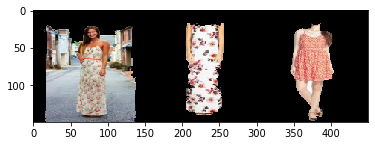

---------- wrong embedding : index 122 -----------


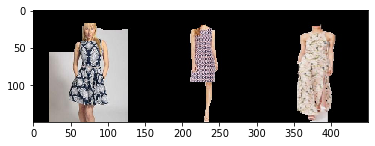

---------- wrong embedding : index 130 -----------


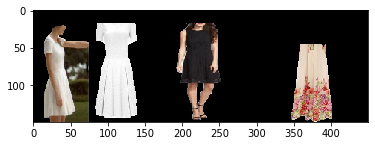

---------- wrong embedding : index 144 -----------


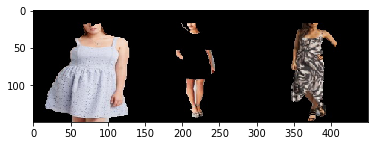

---------- wrong embedding : index 146 -----------


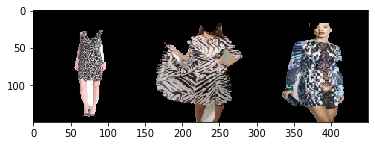

---------- wrong embedding : index 172 -----------


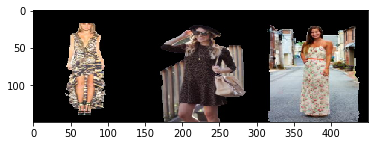

---------- wrong embedding : index 258 -----------


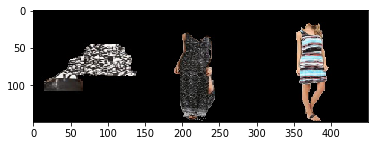

---------- wrong embedding : index 287 -----------


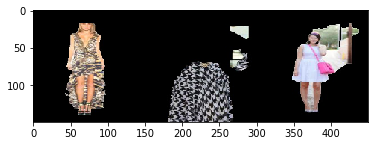

---------- wrong embedding : index 331 -----------


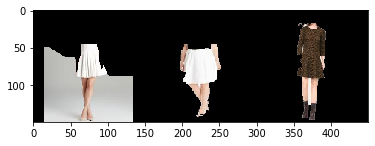

---------- wrong embedding : index 341 -----------


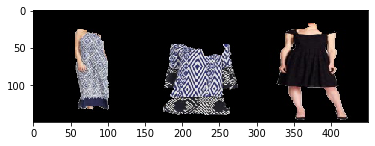

---------- wrong embedding : index 362 -----------


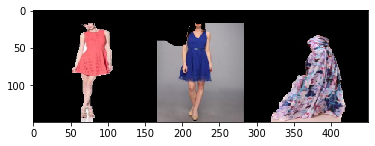

---------- wrong embedding : index 375 -----------


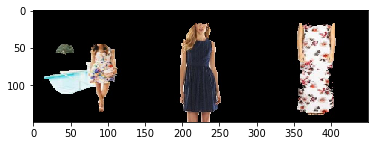

---------- wrong embedding : index 405 -----------


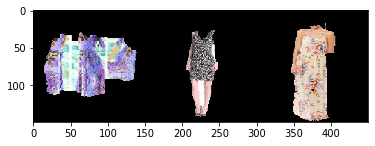

---------- wrong embedding : index 416 -----------


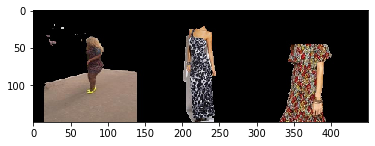

---------- wrong embedding : index 449 -----------


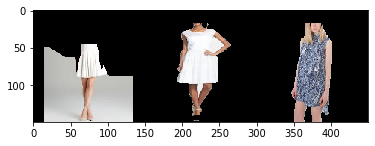

---------- wrong embedding : index 474 -----------


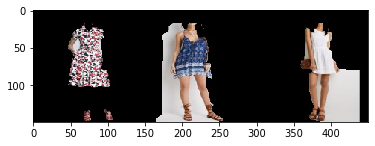

true: 474 false: 26
Accuracy: 0.948


In [35]:
count_true = 0
for k in range(sample_size):
    anchor_encoding = item_to_encoding(t_a[k], base_network)
    pos_encoding = item_to_encoding(t_p[k], base_network)
    neg_encoding = item_to_encoding(t_n[k], base_network)

#     anchor_pos_dist = np.linalg.norm(anchor_encoding-pos_encoding)
#     anchor_neg_dist = np.linalg.norm(anchor_encoding-neg_encoding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding,pos_encoding)),1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding,neg_encoding)),1)
    
    # -ln(-x/N+1)
    anchor_pos_dist = -tf.math.log(-tf.divide((pos_dist),128)+1+1e-8)
    anchor_neg_dist = -tf.math.log(-tf.divide((128-neg_dist),128)+1+1e-8)

    cond = anchor_pos_dist < anchor_neg_dist
    
    if cond: count_true += 1
        
    else: 
        print('---------- wrong embedding : index %d -----------'%k)
        plt.imshow(np.hstack([t_a[k, :, :], t_p[k, :, :], t_n[k, :, :]]))
        plt.show()
        
print("true: {} false: {}".format(count_true, sample_size-count_true))
print("Accuracy: {}".format(count_true / sample_size))

## 6.3 Anchor-all test

In [39]:
#일부만 테스트 + 이미지 출력
thresh = 0.1

anchor = images[100]
anchor_encoding = item_to_encoding(anchor, base_network)

plt.figure(figsize=(150, 150))

cc = 3
rr = int(len(images[:50]) / cc)+1

plt.subplot( rr ,cc, 1)
plt.imshow(anchor, cmap = 'gray')
plt.xlabel("Anchor({})".format(labels[0]), fontsize=80)

correct_count = 0

for k in range(len(images[:50])):        
    i = images[k]          
    plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
    plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    similar = True if dist < thresh else False
    SIM = "SIMILAR" if similar else "NOT SIMILAR"
    cond = labels[0] == labels[k]
    
    if (similar and cond) or (not similar and not cond ):
        c = "blue"
        correct_count += 1
    else: c = "red"
    
    plt.xlabel("{} true label: {} distance from anchor: {:.2f}".format(SIM, labels[k], dist),  color = c, fontsize=80)
    
print("true: {}, false: {}".format(correct_count, 50-correct_count))
print("Accuracy: {}".format(correct_count / 50))

true: 45, false: 5
Accuracy: 0.9


In [40]:
#전체 테스트
#이미지 많이 출력하면 커널 죽어서 이미지 출력은 주석처리
thresh = 0.1

anchor = images[0]
anchor_encoding = item_to_encoding(anchor, base_network)

# plt.figure(figsize=(150, 150))

# cc = 3
# rr = int(len(images[:50]) / cc)+1

# plt.subplot( rr ,cc, 1)
# plt.imshow(anchor, cmap = 'gray')
# plt.xlabel("Anchor({})".format(labels[0]), fontsize=80)

correct_count = 0

for k in range(len(images[:200])):        
    i = images[k]          
#     plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
#     plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    similar = True if dist < thresh else False
    SIM = "SIMILAR" if similar else "NOT SIMILAR"
    cond = labels[0] == labels[k]
    
    if (similar and cond) or (not similar and not cond ):
        c = "blue"
        correct_count += 1
    else: c = "red"
    
#     plt.xlabel("{} true label: {} distance from anchor: {:.2f}".format(SIM, labels[k], dist),  color = c, fontsize=80)
    
print("true: {}, false: {}".format(correct_count, 200-correct_count))
print("Accuracy: {}".format(correct_count / 200))

true: 166, false: 34
Accuracy: 0.83


## 6.4 Anchor-Positive test

In [ ]:
thresh = 0.1

anchor = images[0]
anchor_encoding = item_to_encoding(anchor, base_network)

# plt.figure(figsize=(150, 150))

# cc = 3
# rr = int(len(images[:50]) / cc)+1

# plt.subplot( rr ,cc, 1)
# plt.imshow(anchor, cmap = 'gray')
# plt.xlabel("Anchor({})".format(labels[0]), fontsize=80)

correct_count = 0

for k in range(len(images[:200])):        
    i = images[k]          
#     plt.subplot( rr ,cc, k+2)   # 몇 칼럼 몇 로우로 그래프 그릴지
#     plt.imshow(i, cmap = 'gray')
    item_encoding = item_to_encoding(i, base_network)
    
    dist = tf.reduce_sum(tf.square(tf.subtract(anchor_encoding, item_encoding)),1)
    dist = -tf.math.log(-tf.divide((dist),128)+1+1e-8)
    dist = dist.numpy()[0]
    
    similar = True if dist < thresh else False
    SIM = "SIMILAR" if similar else "NOT SIMILAR"
    cond = labels[0] == labels[k]
    
    if (similar and cond) or (not similar and not cond ):
        c = "blue"
        correct_count += 1
    else: c = "red"
    
#     plt.xlabel("{} true label: {} distance from anchor: {:.2f}".format(SIM, labels[k], dist),  color = c, fontsize=80)
    
print("true: {}, false: {}".format(correct_count, 200-correct_count))
print("Accuracy: {}".format(correct_count / 200))

In [ ]:
def sub_dir(o_dir, n_dir):
    """
    Arguments:
    - o_dir: old directory. 뎁스 바꿔주고 싶은 이미지 폴더(루트)
    e.g. '../../img/mmfashion'
    
    -n_dir: new directory. 새로운 폴더명. 아무거나 상관없음
    e.g. '../../img/mmfashion_flow'
    
    Return:
    없음
    
    """
    dirlist=os.listdir(o_dir)
    for i in dirlist:
        if not os.path.exists(n_dir):
            os.mkdir(n_dir)
        if not os.path.exists(n_dir+'/'+i):
            os.mkdir(n_dir+'/'+i)
        shutil.move(o_dir+"/"+i,n_dir+'/'+i)
        
sub_dir( '../../img/mmfashion',  '../../img/mmfashion_flow')   